In [36]:
# imports
import numpy as np
import cupy as cp
import time
from scipy import ndimage as ndi_cpu # Para la convolución en CPU
from cupyx.scipy import ndimage as ndi_gpu # Para la convolución en GPU
import matplotlib.pyplot as plt

### Ejercicio 1 - Operaciones vectorizadas y comparación CPU vs GPU

In [37]:
def crear_imagen(N, num_fuentes=10, sigma_frac=0.05, usar_gpu=False, seed=42):
    """
    Crea una imagen NxN con varias fuentes puntuales y una gaussiana extendida.
    Compatible con NumPy y CuPy.
    """
    # Seleccionar módulo (np o cp)
    if usar_gpu:
        import cupy as cp
        xp = cp
    else:
        import numpy as np
        xp = np

    # Crear coordenadas y matriz base
    y, x = xp.indices((N, N))
    img = xp.zeros((N, N), dtype=xp.float32)

    # Generador aleatorio
    if usar_gpu:
        rng = cp.random.RandomState(seed)
        xs = rng.randint(0, N, size=num_fuentes)
        ys = rng.randint(0, N, size=num_fuentes)
        amps = rng.uniform(0.3, 1.0, size=num_fuentes)
    else:
        rng = np.random.default_rng(seed)
        xs = rng.integers(0, N, size=num_fuentes)
        ys = rng.integers(0, N, size=num_fuentes)
        amps = rng.uniform(0.3, 1.0, size=num_fuentes)

    # Fuentes puntuales
    for xi, yi, a in zip(xs, ys, amps):
        img[yi, xi] = a

    # Fuente gaussiana extendida en el centro
    sigma = sigma_frac * N
    gauss = xp.exp(-(((x - N/2)**2 + (y - N/2)**2) / (2 * sigma**2)))
    img += 0.8 * gauss

    return img



def kernel_5x5(xp):
    """Filtro 5x5 normalizado (desenfoque gaussiano)"""
    k = xp.array([[1,4,6,4,1],
                  [4,16,24,16,4],
                  [6,24,36,24,6],
                  [4,16,24,16,4],
                  [1,4,6,4,1]], dtype=xp.float32)
    return k / k.sum()



def convolve(image, device='cpu'):
    """
    Convoluciona la imagen con un kernel 5x5 usando CPU o GPU.
    
    Parámetros
    ----------
    image : np.ndarray o cp.ndarray
        Imagen a convolucionar
    device : str
        'cpu' para usar SciPy (CPU), 'gpu' para usar cupyx (GPU)

    Devuelve
    --------
    result : np.ndarray o cp.ndarray
        Imagen convolucionada
    """
    if device == 'cpu':
        kernel = kernel_5x5(np)
        result = ndi_cpu.convolve(image, kernel, mode='reflect')
    elif device == 'gpu':
        kernel = kernel_5x5(cp)
        result = ndi_gpu.convolve(image, kernel, mode='reflect')
    else:
        raise ValueError("device debe ser 'cpu' o 'gpu'")
    
    return result


def ufunc(image, device='cpu'):
    """
    Aplica la función log1p a la imagen usando CPU o GPU.
    """
    if device == 'cpu':
        img = np.log1p(image + 1)
    else:
        img = cp.log1p(image + 1)
    return img

In [38]:
def medir_tiempo(func, repeticiones=5):
    tiempos = []
    for _ in range(repeticiones):
        t0 = time.perf_counter()
        func()
        t1 = time.perf_counter()
        tiempos.append(t1 - t0)
    return np.mean(tiempos), np.std(tiempos)

def comparar_tiempos(N, fuentes, sigma, seed):
    img_cpu = crear_imagen(N, num_fuentes=fuentes, sigma_frac=sigma, usar_gpu=False, seed=seed)
    img_gpu = crear_imagen(N, num_fuentes=fuentes, sigma_frac=sigma, usar_gpu=True, seed=seed)

    def cpu_conv():
        convolve(img_cpu, device='cpu')
    def cpu_ufunc():
        ufunc(img_cpu, device='cpu')
    def gpu_conv():
        convolve(img_gpu, device='gpu')
        cp.cuda.Device().synchronize()
    def gpu_ufunc():
        ufunc(img_gpu, device='gpu')
        cp.cuda.Device().synchronize()

    cpu_conv_time, cpu_conv_std = medir_tiempo(cpu_conv)
    cpu_ufunc_time, cpu_ufunc_std = medir_tiempo(cpu_ufunc)
    gpu_conv_time, gpu_conv_std = medir_tiempo(gpu_conv)        
    gpu_ufunc_time, gpu_ufunc_std = medir_tiempo(gpu_ufunc) 

    speedup_cpu_conv = cpu_conv_time / gpu_conv_time
    speedup_cpu_ufunc = cpu_ufunc_time / gpu_ufunc_time

    print(f"Tamaño imagen: {N}x{N}, Fuentes: {fuentes}, Sigma_frac: {sigma}")
    print(f"Convolución CPU: {cpu_conv_time:.4f} ± {cpu_conv_std:.4f} s")
    print(f"Convolución GPU: {gpu_conv_time:.4f} ± {gpu_conv_std:.4f} s")
    print(f"Speedup convolución: {speedup_cpu_conv:.2f}x")
    print(f"Ufunc CPU: {cpu_ufunc_time:.4f} ± {cpu_ufunc_std:.4f} s")
    print(f"Ufunc GPU: {gpu_ufunc_time:.4f} ± {gpu_ufunc_std:.4f} s")
    print(f"Speedup ufunc: {speedup_cpu_ufunc:.2f}x")
    print("-" * 60)

In [39]:
comparar_tiempos(N=1024, fuentes=80, sigma=0.05, seed=42)

Tamaño imagen: 1024x1024, Fuentes: 80, Sigma_frac: 0.05
Convolución CPU: 0.0138 ± 0.0028 s
Convolución GPU: 0.0003 ± 0.0002 s
Speedup convolución: 50.34x
Ufunc CPU: 0.0041 ± 0.0003 s
Ufunc GPU: 0.0001 ± 0.0000 s
Speedup ufunc: 49.33x
------------------------------------------------------------


### Ejercicio 2 - FFT 2D e imagen sucia en grilla

In [40]:
from functions import read_cfg_to_enu, baselines, enu_to_altaz, hor_to_eq, catalog, ra_dec_to_radians, H_range, eq_to_uvw_array, select_vla_frequencies, uvw_to_lambda_range, generate_random_sources, visibilities_from_sources, max_basline, grid_visibilities, to_fourier

# 1. Lectura de antenas y definición de parámetros del arreglo
# Observatory VLA

latitude = 34.078749
longitude = -107.617728

enu = read_cfg_to_enu("../antenna_arrays/alma.cycle10.8.cfg")

# plot_antennas(enu.T, labels=False, unit="km",title="Configuración de Antenas VLA")

# 2. Obtención de Baselines
baselines_enu = baselines(enu.T, False) 
# 3. Transformacion baseline -> alt, az (Horizontales) -> XYZ (Ecuatoriales)
alt, az = enu_to_altaz(baselines_enu.T, rad=True)
r_eq = hor_to_eq(baselines_enu, alt, az, phi=latitude)

# 4. Transformación XYZ -> uvw

# Delta fijo -> Sirius
sirius_dec = catalog["Sirius"]['Dec']
sirius_ra = catalog["Sirius"]['RA']
delta_src = ra_dec_to_radians(sirius_dec, is_ra=False)
ra_src = ra_dec_to_radians(sirius_ra)

# Rango de horas angulo
times_utc, H, lst = H_range(
    ra_rad=ra_src,
    utc_start="2025-10-10 00:00:00",
    utc_end="2025-10-10 12:00:00",
    longitude=longitude,
    step_minutes=5
)

# Obtención muestreo
uvw = eq_to_uvw_array(H, delta_src, r_eq)
# 6. Transformación a longitud de Onda
frequencies = select_vla_frequencies("L", 4)
uvw_lambda, wavelengths = uvw_to_lambda_range(uvw, frequencies)

ra0_deg = np.degrees(ra_dec_to_radians(catalog['Sirius']['RA']))  # Sirius A
dec0_deg = np.degrees(ra_dec_to_radians(catalog['Sirius']['Dec']))
sources = generate_random_sources(ra0_deg, dec0_deg, N=2, max_offset_deg=0.1, flux_range=(0.2, 1.0), seed=42)

V, omega, l_src, m_src, n_src = visibilities_from_sources(uvw_lambda, sources, ra0_deg, dec0_deg)

print(f"Simuladas {len(sources)} fuentes puntuales.")
print(f"Visibilidades: {V.shape}")

# Resolucion
N = 512
N = [512, 1024, 2048, 4096, 8192]
# Distancion maxima entre baselines
Dmax = max_basline(baselines_enu)
oversampling_factor = 4

c = 299792458.0 
freq = np.min(frequencies)
min_wavelenghgt = c / freq
dx = dy = (min_wavelenghgt / Dmax) / oversampling_factor

imgs = []

for res in N:
    du = 1.0 / (res * dx)
    dv = du
    VG, WG, VG_sum = grid_visibilities(V, uvw_lambda, du, dv,Npix=res)
    imgs.append(VG_sum)

Simuladas 2 fuentes puntuales.
Visibilidades: (903, 145, 4)


c:\Users\vicen\Repositories\RadioInterferometry\GPU\functions.py:426: ComplexWarning: Casting complex values to real discards the imaginary part
  np.add.at(WG[..., f], (j[mask], i[mask]), omega_f[mask])


In [41]:
def times_ex_2(imgs_np):
    
    imgs_cp = list(map(cp.asarray, imgs_np))
    
    times_cpu = []
    times_gpu = []

    # --- CPU ---
    for img in imgs_np:
        start = time.perf_counter()
        _ = to_fourier(img, use_gpu=False)
        end = time.perf_counter()
        times_cpu.append(end - start)

    # --- GPU ---
    for img_cp in imgs_cp:
        start = time.perf_counter()
        _ = to_fourier(img_cp, use_gpu=True)
        # aseguramos que la GPU termine antes de medir el tiempo
        cp.cuda.Device().synchronize()
        end = time.perf_counter()
        times_gpu.append(end - start)

    speedup = np.array(times_cpu) / np.array(times_gpu)
    return times_cpu, times_gpu, speedup

    

In [42]:
times_cpu, times_gpu, speedup = times_ex_2(imgs)

In [43]:
times_cpu

[0.008251800001744414,
 0.042156999999861,
 0.1824840999997832,
 0.7230885999997554,
 3.1944430000003194]

In [44]:
times_gpu

[0.0705469999993511,
 0.0013032000006205635,
 0.005519899999853806,
 0.025754299998880015,
 0.11955790000138222]

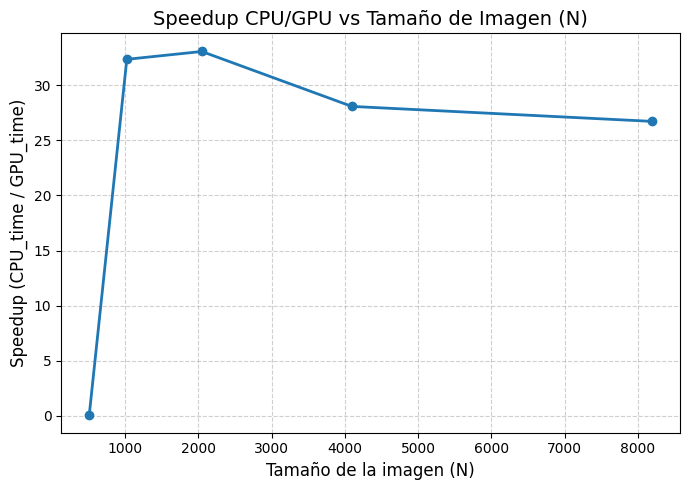

In [46]:
# Crear gráfico
plt.figure(figsize=(7,5))
plt.plot(N, speedup, marker='o', linewidth=2)
plt.title("Speedup CPU/GPU vs Tamaño de Imagen (N)", fontsize=14)
plt.xlabel("Tamaño de la imagen (N)", fontsize=12)
plt.ylabel("Speedup (CPU_time / GPU_time)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()